In [1]:
from hankel import SymmetricFourierTransform
from scipy.interpolate import InterpolatedUnivariateSpline as spline
from hmf import Transfer
import numpy as np
import matplotlib.pyplot as plt
from powerbox import PowerBox, get_power, LogNormalPowerBox
from numpy.fft import fftn,ifftn,ifftshift,fftshift,fftfreq
%matplotlib inline

## Test transform

### Create Underlying Power Spectrum (cosmo)

In [2]:
tr = Transfer(transfer_model="EH_NoBAO")
spl_ln = spline(np.log(tr.k),np.log(tr.power),k=2)
spl = lambda k : np.exp(spl_ln(np.log(k)))

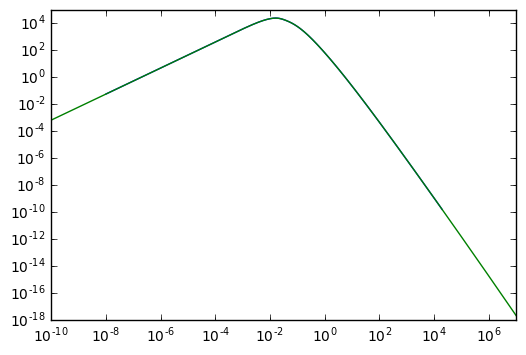

In [6]:
plt.plot(tr.k,spl(tr.k))
plt.plot(np.logspace(-10,7,500),spl(np.logspace(-10,7,500)))
plt.xscale('log')
plt.yscale('log')

### Create PowerBox Instance to set res params

In [3]:
pb = PowerBox(200,spl, 3, boxlength=100.0,seed=1234)

In [4]:
finalk = np.logspace(np.log10(pb.k[pb.k!=0].min()),np.log10(pb.k.max()),200)

In [5]:
ht_fwd = SymmetricFourierTransform(ndim=3,N=4000,h=0.001)  # From power to xi
ht_bwd = SymmetricFourierTransform(ndim=3,N=4000,h=0.001)  # From xi(ish) to power

In [6]:
rmin = ht_bwd.x.min()/finalk.max()
rmax = ht_bwd.x.max()/finalk.min()

r = np.logspace(np.log10(rmin),np.log10(rmax),5000)

### Do forward transform

In [7]:
xir = ht_fwd.transform(spl,r,ret_err=False,inverse=True)

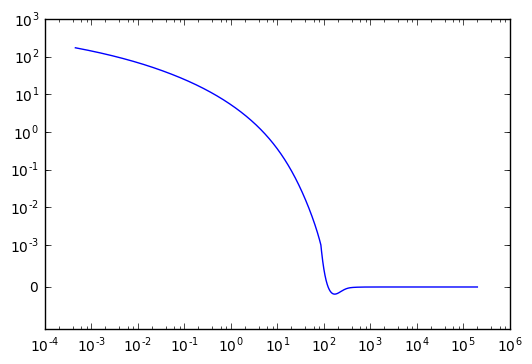

In [22]:
plt.plot(r,xir)
plt.xscale('log')
plt.yscale('symlog',linthreshy=1e-3)

In [8]:
spl_xir = spline(r,xir)
spl_lin_xir = spline(r,np.log(1+xir))

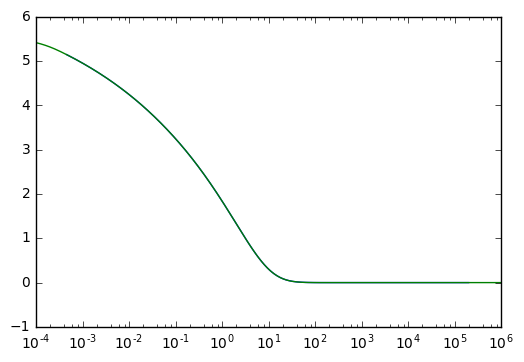

In [30]:
plt.plot(r,spl_lin_xir(r))
plt.plot(np.logspace(-4,6,300),spl_lin_xir(np.logspace(-4,6,300)))
plt.xscale('log')

### Do backward transform

In [9]:
finalp = ht_bwd.transform(spl_xir,finalk,ret_err=False)
finalp_lin = ht_bwd.transform(spl_lin_xir,finalk,ret_err=False) 

(0.01, 100000.0)

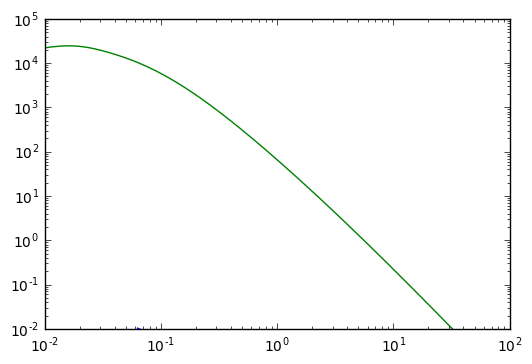

In [33]:
plt.plot(finalk,finalp)
plt.plot(tr.k,tr.power)
plt.xscale('log')
plt.yscale('log')
plt.xlim((1e-2,1e2))
plt.ylim((1e-2,1e5))

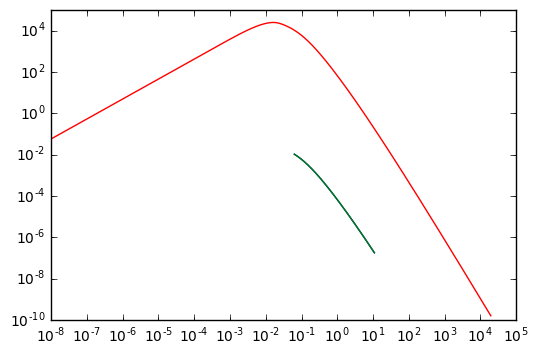

In [34]:
plt.plot(finalk,finalp_lin)
plt.plot(finalk,np.abs(finalp_lin))
plt.plot(tr.k,tr.power)

plt.xscale('log')
plt.yscale('log')

## Make a powerbox

In [10]:
power_fn = spline(finalk,finalp_lin)

In [13]:
pb_s.delta_x

In [11]:
## Basically copy powerbox
pb_s = PowerBox(pb.N,power_fn,pb.dim,boxlength=pb.boxlength)
s_x = pb_s.delta_x

delta_x = np.exp(pb_s.delta_x - np.var(pb_s.delta_x)/2) - 1

In [14]:
print s_x.min(),s_x.max()
print delta_x.min(), delta_x.max()

-8.67982826963 8.44683064517
-0.999958502337 1136.72446344


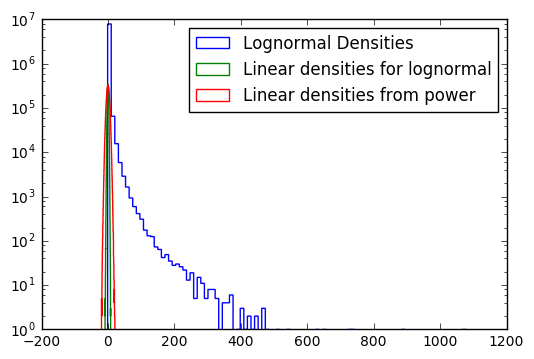

In [12]:
plt.hist(delta_x.flatten(),bins=100,histtype='step',label="Lognormal Densities")
plt.hist(s_x.flatten(),bins=100,histtype='step',label="Linear densities for lognormal")
plt.hist(pb.delta_x.flatten(),bins=100,histtype='step',label="Linear densities from power")

# plt.yscale('log')
plt.legend(loc=0)
plt.yscale('log')
plt.show()

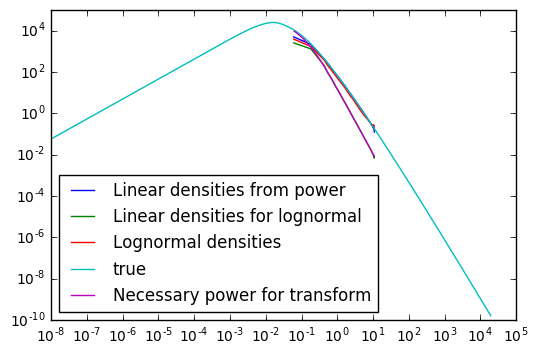

In [13]:
p_k_lin, centres = get_power(pb.delta_x,pb.k,V=pb.V)
p_k,centres = get_power(delta_x, pb.k,pb.V)
p_k_s,centres = get_power(s_x, pb.k,pb.V)

plt.plot(centres,p_k_lin,label='Linear densities from power')
plt.plot(centres,p_k_s,label="Linear densities for lognormal")
plt.plot(centres,p_k,label="Lognormal densities")

plt.plot(tr.k,tr.power,label="true")
plt.plot(finalk,finalp_lin,label="Necessary power for transform")
plt.legend(loc=0)
plt.xscale('log')
plt.yscale('log')

## Florian's Method

In [14]:
lnpb = LogNormalPowerBox(pb.N,spl,pb.dim,boxlength=pb.boxlength,seed=1234)

In [20]:

pbox = np.zeros_like(pb.k)
pbox[pb.k!=0] = spl(pb.k[pb.k!=0])

xir = 1./pb.V * np.real(pb.N**pb.dim * ifftn(ifftshift(pbox)))
xir = np.log(1+xir)

xir = fftshift(xir) ## testing

## Check out xir against mine
_,indx = np.unique(pb.r.flatten(),return_index=True)
xx = xir.flatten()[indx][np.argsort(pb.r.flatten()[indx])]
rthis = np.sort(pb.r.flatten()[indx])
xir_spl = spline(rthis,xx)
###########

pbox = pb.V*fftn(xir)/pb.N**pb.dim
pbox = fftshift(np.abs(pbox))

## Check out pbox against mine
_,indx = np.unique(pb.k.flatten(),return_index=True)
pp = pbox.flatten()[indx][np.argsort(pb.k.flatten()[indx])]
kthis = np.sort(pb.k.flatten()[indx])
pp_spl = spline(kthis,pp)
###########

np.clip(pbox,0,None,pbox)

delta_k = np.zeros_like(pb.k)
delta_k[pb.k!=0] = pb.gauss_hermitian[pb.k!=0] * np.sqrt(pbox[pb.k!=0])
delta_x = (1./np.sqrt(pb.V))*np.real(pb.N**pb.dim*ifftn(ifftshift(delta_k)))

sigma_g = np.var(delta_x)
print np.mean(delta_x)

densities = np.exp(delta_x - sigma_g/2)-1

/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


4.23483470513e-18


In [27]:
np.angle?

In [25]:
pb.gauss_hermitian/lnpb.gauss_hermitian

array([[[ 1. +0.00000000e+00j,  1. +0.00000000e+00j,  1. +0.00000000e+00j,
         ...,  1. -0.00000000e+00j,  1. -0.00000000e+00j,
          1. +0.00000000e+00j],
        [ 1. +0.00000000e+00j,  1. +0.00000000e+00j,  1. +0.00000000e+00j,
         ...,  1. +0.00000000e+00j,  1. -0.00000000e+00j,
          1. -5.07076289e-17j],
        [ 1. -0.00000000e+00j,  1. -0.00000000e+00j,  1. -0.00000000e+00j,
         ...,  1. -0.00000000e+00j,  1. -0.00000000e+00j,
          1. +0.00000000e+00j],
        ..., 
        [ 1. -0.00000000e+00j,  1. +5.70540834e-17j,  1. -0.00000000e+00j,
         ...,  1. +0.00000000e+00j,  1. +0.00000000e+00j,
          1. -0.00000000e+00j],
        [ 1. -0.00000000e+00j,  1. -0.00000000e+00j,  1. +0.00000000e+00j,
         ...,  1. +0.00000000e+00j,  1. -0.00000000e+00j,
          1. -0.00000000e+00j],
        [ 1. +0.00000000e+00j,  1. +5.69548914e-17j,  1. +0.00000000e+00j,
         ...,  1. -0.00000000e+00j,  1. -0.00000000e+00j,
          1. +0.00000000e+00

In [50]:
kk = fftshift(fftfreq(10))
print ifftshift(kk)

[ 0.   0.1  0.2  0.3  0.4 -0.5 -0.4 -0.3 -0.2 -0.1]


In [45]:
xir[199,199,199]

1.9460709044840854

In [36]:
xir_spl(1)

array(-0.01891997063457944)

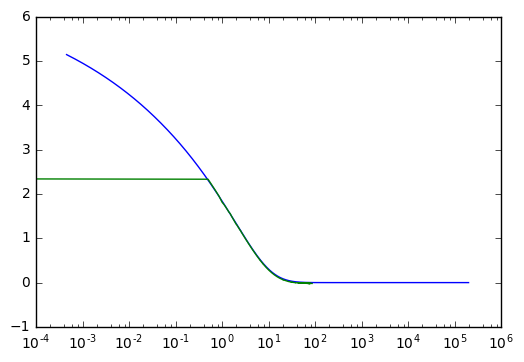

In [52]:
plt.plot(r,spl_lin_xir(r))
plt.plot(rthis,xir_spl(rthis))
plt.xscale('log')

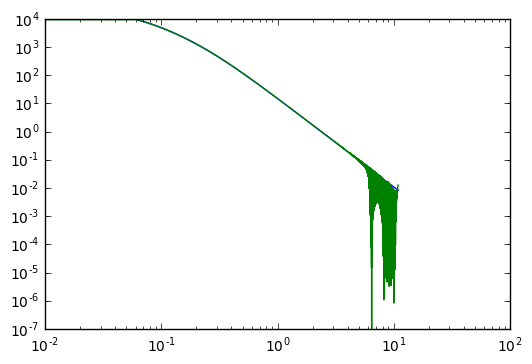

In [67]:
plt.plot(finalk,finalp_lin)
plt.plot(kthis,pp_spl(kthis))
plt.xscale('log')
plt.yscale('log')

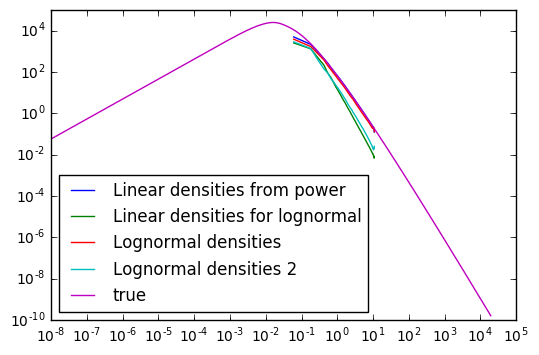

In [27]:
p_k,centres = get_power(lnpb.delta_x, lnpb.k,lnpb.V)
p_k_,_ = get_power(densities, lnpb.k,lnpb.V)

plt.plot(centres,p_k_lin,label='Linear densities from power')
plt.plot(centres,p_k_s,label="Linear densities for lognormal")
plt.plot(centres,p_k,label="Lognormal densities")
plt.plot(centres,p_k_,label="Lognormal densities 2")

plt.plot(tr.k,tr.power,label="true")
#plt.plot(finalk,finalp_lin,label="Necessary power for transform")
plt.legend(loc=0)
plt.xscale('log')
plt.yscale('log')

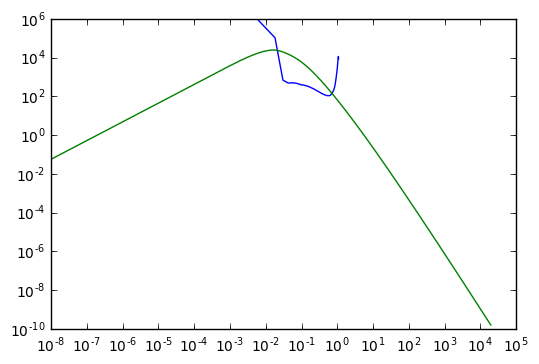

In [70]:
plt.plot(centres,pk*V)
plt.plot(tr.k,tr.power)
plt.xscale('log')
plt.yscale('log')


In [71]:
x =np.zeros((10,10,10))
x.size

1000

In [77]:
## Use Greiner method

dim = 3
L = 1000
V = 1000**dim
N = 200
dx = L/N

## Define FT as they do
# def fft3(x):
#     return x.size*ifftn(x)

# def ifft3(x):
#     return 

tr = Transfer(transfer_model="EH_NoBAO")
spl_ln = spline(np.log(tr.k),np.log(tr.power),k=2)
Pk = lambda k : np.exp(spl_ln(np.log(k)))

pb = PowerBox(N,Pk,dim=3,boxlength=L)
kbox = pb.k #np.sqrt(np.add.outer(np.add.outer(kgrid**2,kgrid**2),kgrid**2))

Vx = dx**dim
Vk = 1./(N**dim * Vx)

prho = np.zeros_like(kbox)
prho[kbox!=0] = Pk(kbox[kbox!=0])
prho[kbox==0] = V*1

logxi = np.log(fftn(prho * Vk))
Ps = np.real(N**dim * Vx* ifftn(logxi))
m = Vk*Vx* np.sum(logxi) - np.log(Vk*np.sum(prho))/2

mag = np.random.normal(0, 1, size=[N+1]*dim)
pha = 2*np.pi*np.random.uniform(size=[N+1]*dim)
delta_k = pb._make_hermitian(mag,pha)
if N%2==0:
    cutidx = [slice(None,-1)]*dim
    delta_k = delta_k[cutidx]

P = np.zeros_like(kbox)
P[kbox != 0] = np.sqrt(Ps[kbox != 0])
delta_k *= P

s_x = np.real(N ** dim*fftn(delta_k))

delta_x = np.exp(s_x + m ) - 1

/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:42: RuntimeWarning: invalid value encountered in sqrt
/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in exp


In [29]:
pos = lnpb.create_discrete_sample(0.1)

(98216, 3)


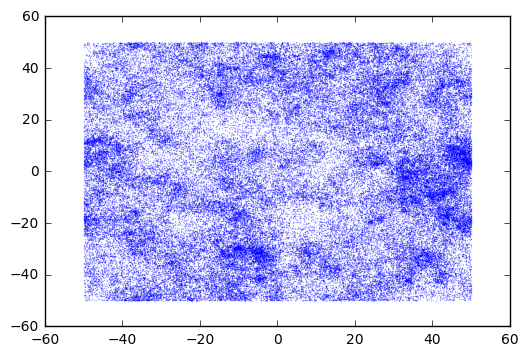

In [30]:
thispos = pos[pos[:,2]>-50.0]
print thispos.shape
plt.scatter(thispos[:,0],thispos[:,1],s=1,lw=0,alpha=0.3)
